### This notebook computes the predicitive distribution of a GP with physics enhanced kernel where the hyperparameters of the kernel have been learnt in the TrainGP notebook.

In [2]:
import torch
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal as MN
import matplotlib.pyplot as plt
import seaborn as sns

import SEGP as SEGP
import PlotGP as PGP
import GP_Tools as GP


### Load data and model.

In [5]:

# ----------------------------------------- user settings --------------------------------------------------------

# dataset
D = 1
data_path = '/qfs/projects/atscale/atscale_dyn/Data/GP/Data/Dataset{0}/'.format(D)
N = 20 # number of observed data points

# model
exp_no = 1 # experiment number
model_name = 'SEGP/'
model_dir = '/qfs/projects/atscale/atscale_dyn/Data/GP/Models/' + model_name + 'Exp_{:03d}/'.format(exp_no)
true_params = False # Loads ground truth parameter values into model if set as true

B = torch.tensor([[0, 0],
                  [0, 0],
                  [1, 0],
                  [0, 1]], dtype=torch.double)
        
C = torch.tensor([[1, 0, 0, 0], 
                  [0, 1, 0, 0]], dtype=torch.double)

D = torch.zeros((2,2), dtype=torch.double)

# ----------------------------------------------------------------------------------------------------------------

with open(data_path+'exp_setup.npy', 'rb') as f:
    exp_setup = np.load(f, allow_pickle=True)
with open(data_path+'LTI_params.npy', 'rb') as f:
    LTI_params = np.load(f, allow_pickle=True)
with open(model_dir+'run_settings.pkl', 'rb') as f:
    run_settings = np.load(f, allow_pickle=True)
    
# sampled signals
with open(data_path+'dT.npy', 'rb') as f:
    dT = torch.from_numpy( np.load(f) ).double()
with open(data_path+'mean_U_dt.npy', 'rb') as f:
    mean_U_dt = torch.from_numpy(  np.load(f) ).double() # (len(dT),p) 
with open(data_path+'U_dt_all.npy', 'rb') as f:
    U_dt_all = torch.from_numpy( np.load(f) ).double() # (exp_no, batch, len(dT), p)
with open(data_path+'Y_dt_all.npy', 'rb') as f:
    Y_dt_all = torch.from_numpy( np.load(f) ).double() # (exp_no, batch, len(dT), m)
with open(data_path+'Y_tilde_dt_all.npy', 'rb') as f:
    Y_tilde_dt_all = torch.from_numpy( np.load(f) ).double() # (exp_no, batch, len(dT), m)

# continuous mean of U
with open(data_path+'mean_U.npy', 'rb') as f:
    mean_U = torch.from_numpy(  np.load(f) ).double() # (len(T), p) 
    
LTI_params = LTI_params.tolist()
exp_setup = exp_setup.tolist()

max_epoch = run_settings['max_epoch']
exp_no = exp_setup['exp_no']
batch = exp_setup['batch']

m = exp_setup['m'] # dimension of output
n = exp_setup['n'] # dimension of state
p = exp_setup['p'] # dimension of input
lt = exp_setup['lt']
time = exp_setup['time']
mean_x0 = torch.from_numpy( exp_setup['mean_x0'] ).double()
cov_x0 = torch.from_numpy( exp_setup['cov_x0'] ).double()
cov_eta = torch.from_numpy( exp_setup['cov_eta'] ).double()
tmax = len(dT)
model = SEGP.SEGP(m, n, p, lt, time, mean_x0, mean_U, mean_U_dt, cov_x0, cov_eta, tmax, B, C, D)
model.load_state_dict( torch.load(model_dir + 'epoch{:03d}.pt'.format(max_epoch)) )
model.eval()

# sample random trajectory
rand_exp = np.random.randint(0, exp_no)
rand_batch = np.random.randint(0, batch)
Y_dt = Y_dt_all[rand_exp, rand_batch]
Y_tilde_dt = Y_tilde_dt_all[rand_exp, rand_batch]

# randomly sample observed datapoints
obs_indices = np.random.randint(0, len(dT)-1, N) # may include repititions!
dT_obs = dT[obs_indices]
Y_tilde_dt_obs = Y_tilde_dt[obs_indices]
mean_U_dt_obs = mean_U_dt[obs_indices]
Y_dt_obs = Y_dt[obs_indices] # for plotting figures against ground truth


### Compute prior and predictive distributions

In [6]:

model.set_ABCD()

if true_params:
    model.A = torch.tensor(LTI_params['A'], dtype=torch.double)
    model.B = torch.tensor(LTI_params['B'], dtype=torch.double)
    model.C = torch.tensor(LTI_params['C'], dtype=torch.double)
    model.D = torch.tensor(LTI_params['D'], dtype=torch.double)

mu_prior_obs = GP.mean(model.m, dT_obs, model.mean_x0, model.mean_U, mean_U_dt_obs, time, model.A, 
                    model.B, model.C, model.D)

mu_prior_pred = GP.mean(model.m, dT, model.mean_x0, model.mean_U, model.mean_U_dt, time, model.A, 
                     model.B, model.C, model.D)

K_joint_mat = GP.K_joint(model.m, dT, dT_obs, model.time[2], model.lt, model.cov_x0, model.A, 
                      model.B, model.C, model.D)

mu_pred, K_pred = GP.pred(K_joint_mat, mu_prior_obs, mu_prior_pred, cov_eta, Y_tilde_dt_obs)


mean_0 complete!
mean_1 complete!
mean_0 complete!
mean_1 complete!
K_00 complete!
K_01 complete!
K_11 complete!
K_joint_00 complete!
K_00 complete!
K_01 complete!
K_10 complete!
K_11 complete!
K_joint_01 complete!
K_joint_10 complete!
K_00 complete!
K_01 complete!
K_11 complete!
K_joint_11 complete!


In [7]:
# checks and detach for plotting

# check tolerances if these fail
GP.test_K(K_joint_mat)
GP.test_K(K_pred)


mu_prior_obs = mu_prior_obs.detach().numpy()
mu_prior_pred = mu_prior_pred.detach().numpy()
K_joint_mat = K_joint_mat.detach().numpy()
mu_pred = mu_pred.detach().numpy()
K_pred = K_pred.detach().numpy()


### Plots

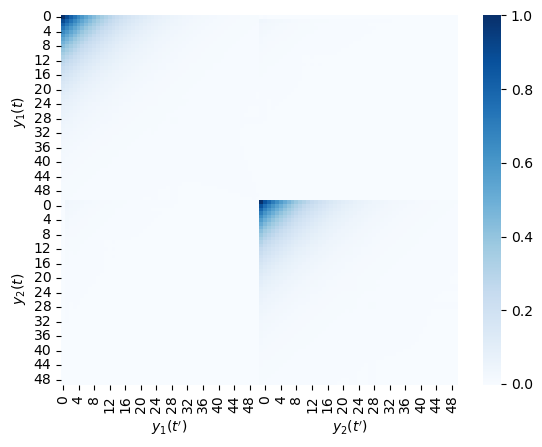

0

In [8]:
# Plot K prior pred - this is the prior for both the observed and unobserved data.
tmax1 = len(dT)
file = 'K_prior'
PGP.plot_K(K_joint_mat[0:m*tmax1, 0:m*tmax1], model_dir, file)

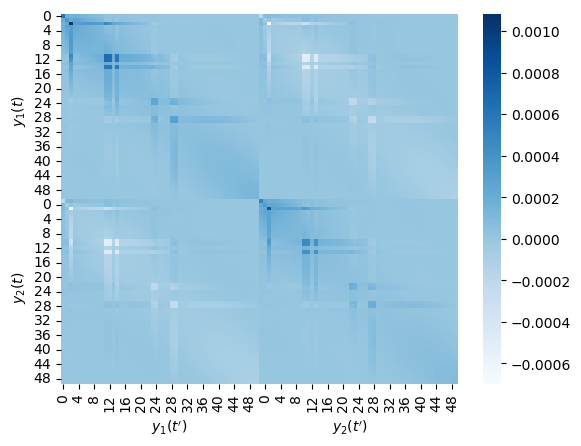

0

In [9]:
# Plot predictive K
file = 'K_pred'
PGP.plot_K(K_pred, model_dir, file)

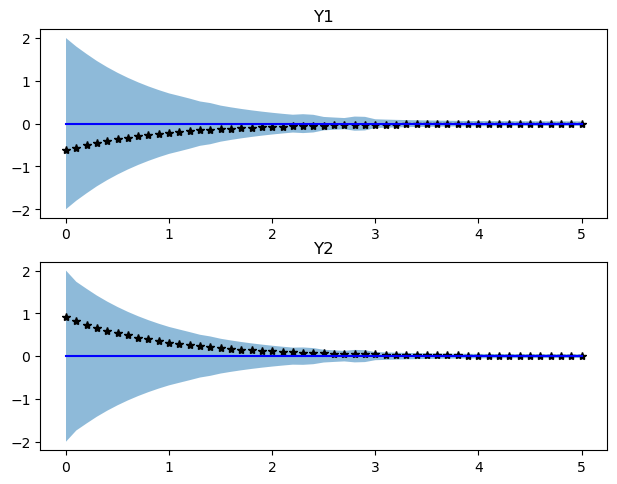

0

In [10]:
# plot prior against unobserved data.
file = 'GP_prior'
Y_test_stacked = GP.stack_traj(Y_dt) # ground truth
PGP.plot_GP(mu_prior_pred, K_joint_mat[0:m*tmax1, 0:m*tmax1], Y_test_stacked, dT, model_dir, file)

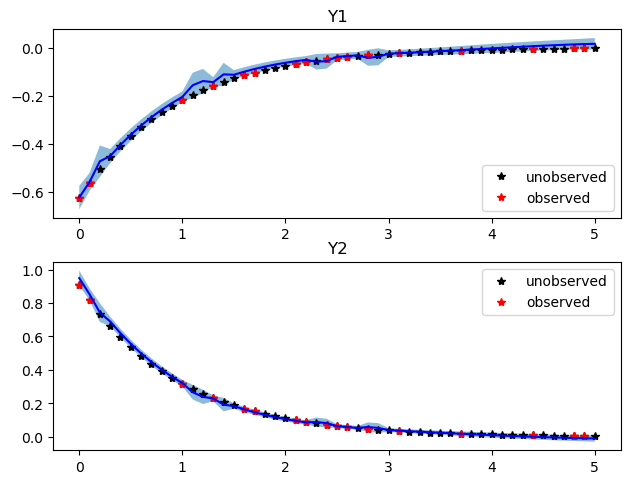

Predictive distribution using N =< 20 randomly sampled training points out of 51. Some of these 
          training points may be repititions as they have been randomly sampled.


In [11]:
# plot predictive against all data
file = 'GP_pred'
PGP.plot_GP(mu_pred, K_pred, Y_test_stacked, dT, model_dir, file, train_indices=obs_indices)
text = """Predictive distribution using N =< {0} randomly sampled training points out of {1}. Some of these 
          training points may be repititions as they have been randomly sampled.""".format(N, len(dT))
print(text)

### Comparing model parameters with ground truth

In [12]:
print(model.A)
print(LTI_params['A'])

tensor([[-1.8785e-01,  1.2447e+00,  2.1262e+00,  6.9627e-02],
        [-7.0112e-01, -2.0338e+00, -1.7138e+00, -3.8042e-02],
        [-1.6319e+01,  9.6524e+00, -1.9909e+01,  1.8442e+01],
        [-1.7200e+01, -5.9691e+01, -6.5132e+01, -2.2720e+01]],
       dtype=torch.float64, grad_fn=<AddBackward0>)
[[-1. -0. -0. -0.]
 [-0. -1. -0. -0.]
 [-0. -0. -1. -0.]
 [-0. -0. -0. -1.]]


In [11]:
print(model.B)
print(LTI_params['B'])

tensor([[0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 1.]], dtype=torch.float64)
[[0 0]
 [0 0]
 [1 0]
 [0 1]]


In [12]:
print(model.C)
print(LTI_params['C'])

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.]], dtype=torch.float64)
[[1 0 0 0]
 [0 1 0 0]]


In [13]:
print(model.D)
print(LTI_params['D'])

tensor([[0., 0.],
        [0., 0.]], dtype=torch.float64)
[[0. 0.]
 [0. 0.]]
